<a href="https://colab.research.google.com/github/osadly/Courses/blob/main/Homework_M3_3OCT24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment
Build the AlexNet architecture and train it on the CIFAR10 dataset.

You may resize some of the kernel sizes (mainly the first one) and the number of kernels because CIFAR100 is a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

You may resize the number of kernels used per layer if it speeds up training and/or preserves accuracy. The exact AlexNet architecture and number of units will not work.

Report training, validation and test errors. Which hyperparameters did you change to improve performance?

**MAKE SURE YOU USE A GPU!** Top menu select "Runtime", then "Runtime Type". Make sure "Hardware Accelerator" has the option "GPU" selected.

Tips:
- Start with only a few of a layers and check if the network can learn.
- Add units and layers progressively.
- Kernels that are too large or too much pooling will reduce the size of layer ouputs
- Try Batch Norm and Dropout
- If you don't reproduce the exact architecture, that is fine. Explain what you changed and why!.
- Functional API!


In [11]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

#TF Version & GPUs available
print('TF Version: ' + str(tf.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

!nvidia-smi

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TF Version: 2.17.0
Num GPUs Available:  1
Fri Oct  4 00:23:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              28W /  70W |   2155MiB / 15360MiB |      0%      Default |
|                                         |  

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


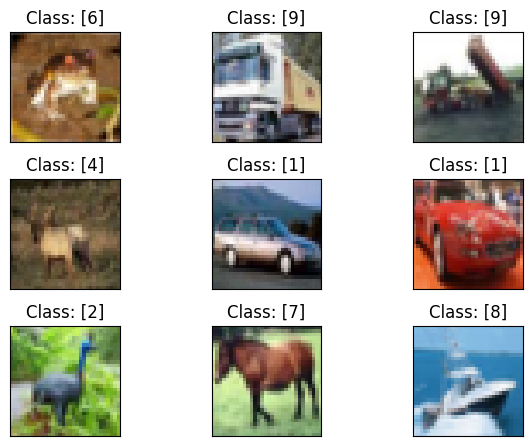

In [13]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train_full[i], interpolation='none')
  plt.title('Class: {}'.format(y_train_full[i]))
  plt.xticks([])
  plt.yticks([])

In [14]:
X_train_full.shape

(50000, 32, 32, 3)

In [15]:
from tensorflow.keras import layers
import random
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

### Train, Validate & Test

In [26]:
# Split into train_full & test
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

print("X_train_full.shape", X_train_full.shape) # (50000, 32, 32, 3)
print("y_train_full.shape", y_train_full.shape) # (50000, 1)
print("X_test.shape", X_test.shape)             # (10000, 32, 32, 3)
print("y_test.shape", y_test.shape)             # (10000, 1)

X_train_full.shape (50000, 32, 32, 3)
y_train_full.shape (50000, 1)
X_test.shape (10000, 32, 32, 3)
y_test.shape (10000, 1)


In [27]:
# Split train_full into train & test
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=47)
print(X_train.shape)  # (40000, 32, 32, 3)
print(X_val.shape)    # (10000, 32, 32, 3)
print(y_train.shape)  # (40000, 1)
print(y_val.shape)    # (10000, 1)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)


### AlexNet Functional API

Model: "CIFAR10_AlexNet_by_Sam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputCIFAR10 (InputLayer)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C1 (Conv2D)                          │ (None, 30, 30, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool1 (MaxPooling2D)              │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      77,074,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,899,402 (358.20 MB)

 Trainable params: 93,899,402 (358.20 MB)

 Non-trainable params: 0 (0.00 B)

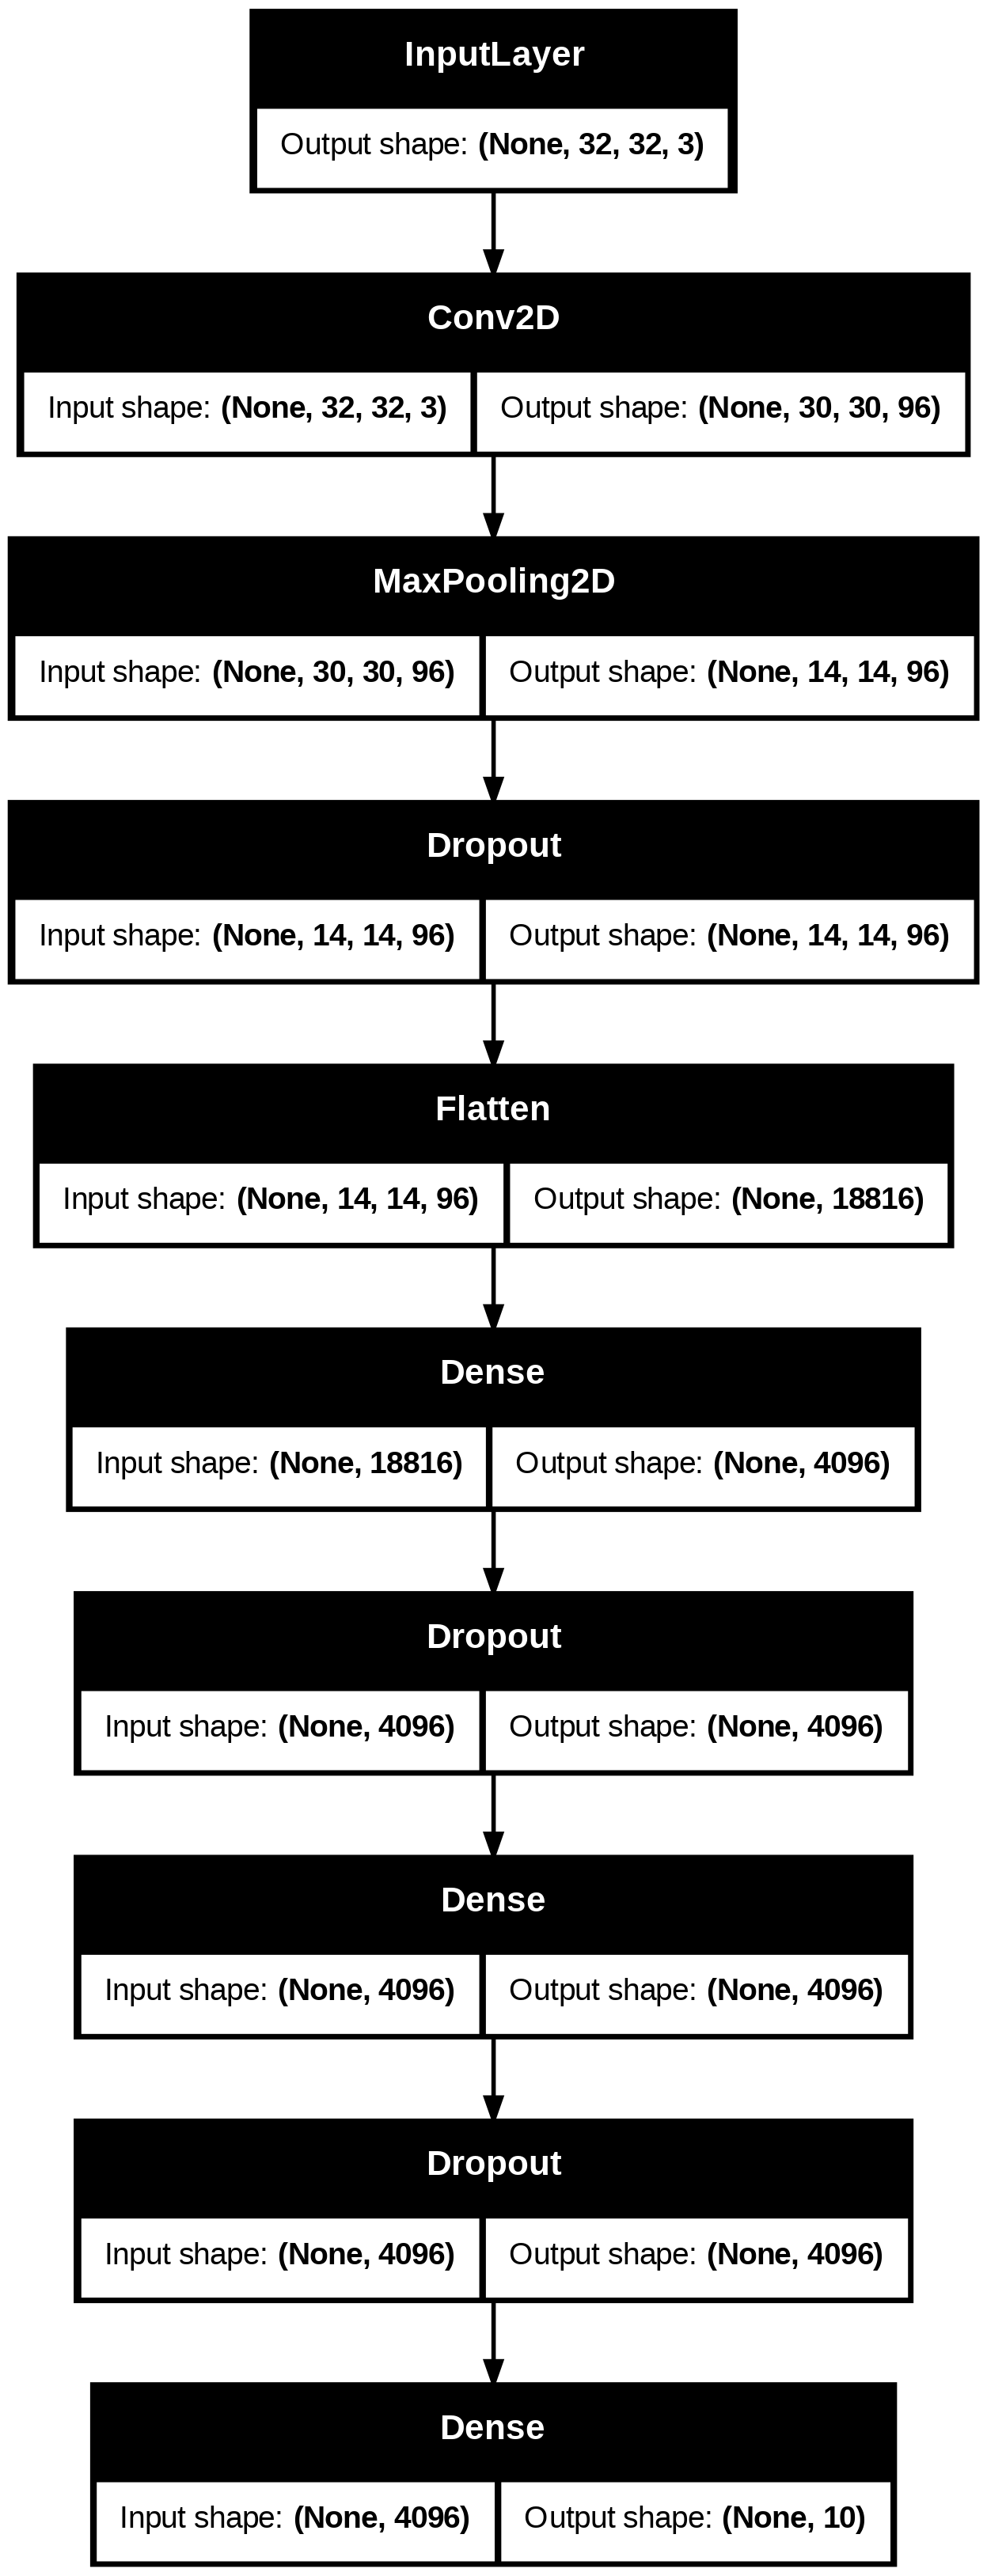

In [17]:
K.clear_session()

inputs = keras.Input(shape=(32, 32, 3), name='inputCIFAR10')

# 1st convolutional layer
x=layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding='valid', name='Conv1')(inputs)
x=layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool1')(x)
x=layers.Dropout(0.5)(x)

# Dense Layer
flat = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(flat)
x = layers.Dropout(0.4)(x)

x=layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='CIFAR10_AlexNet_by_Sam')
model.summary()
keras.utils.plot_model(model, show_shapes=True)